## Introduction
** **
Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

- **Dimensionality Reduction**, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}
- **Unsupervised Learning**, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight
- **Tagging**, abstract “topics” that occur in a collection of documents that best represents the information in them.

There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

In this tutorial, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation in python 2.7

### Theoretical Overview
LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

![LDA_Model](https://github.com/chdoig/pytexas2015-topic-modeling/blob/master/images/lda-4.png?raw=true)

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:

- `psi`, the distribution of words for each topic K
- `phi`, the distribution of topics for each document i

#### Parameters of LDA

- `Alpha parameter` is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
- `Beta parameter` is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

**To read more: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0**

** **
### LDA Implementation

1. [Loading data](#load_data)
2. [Data cleaning](#clean_data)
3. [Exploratory analysis](#eda)
4. [Prepare data for LDA analysis](#data_preparation)
5. [LDA model training](#train_model)
6. [Analyzing LDA model results](#results)

** **
For this tutorial, we’ll use the dataset of papers published in NeurIPS (NIPS) conference which is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NeurIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

<img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_158/img/nips_logo.png" alt="The logo of NIPS (Neural Information Processing Systems)">

Let’s start by looking at the content of the file

** **
#### Step 1: Loading Data <a class="anchor\" id="load_data"></a>
** **

In [ ]:
import SouperDuper as SD
import pandas as pd
corpus = []
agniYoga = "https://subtlerealm.org"

SubtleRealm = SD.Souper(agniYoga)
SubtleRealmSoup = SubtleRealm.scoop()
for lnk in SubtleRealmSoup.findAll("a"):
    corpus.append(agniYoga+lnk.get("href"))       
#for s in tOCSoup.find_all("ul",attrs={"id":"navRight"}):
corpus.pop()
scrapes = [SD.Souper(url).scoop() for url in corpus]
stext =[s.text for s in scrapes]
scraped = pd.DataFrame(data = {"url": corpus,"raw_text":stext} )
scraped.to_csv("subtlerealm.csv")

In [2]:
# Importing modules
import pandas as pd
import os

os.chdir('..')

# Read data into papers
papers = pd.read_csv('C:\\subtlerealm\\jupyter\\subtlerealm.csv')

# Print head
papers.head()

,Unnamed: 0,url,raw_text
0,0,https://subtlerealm.org#main-content,\n\n\n\n\n\n\n\n\nWelcome to Subtle Realm | Su...
1,1,https://subtlerealm.org/user/login,\n\n\n\n\n\n\nLog in | SubtleRealm\n\n\n\n\n\n...
2,2,https://subtlerealm.org/user/register,\n\n\n\n\n\n\n\nRegister | SubtleRealm\n\n\n\n...
3,3,https://subtlerealm.org/,\n\n\n\n\n\n\n\n\nWelcome to Subtle Realm | Su...
4,4,https://subtlerealm.org/,\n\n\n\n\n\n\n\n\nWelcome to Subtle Realm | Su...


** **
#### Step 2: Data Cleaning <a class="anchor\" id="clean_data"></a>
** **

Since the goal of this analysis is to perform topic modeling, let's focus only on the text data from each paper, and drop other metadata columns. Also, for the demonstration, we'll only look at 100 papers

##### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of `paper_text` column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [3]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = \
papers['raw_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

0    \n\n\n\n\n\n\n\n\nwelcome to subtle realm | su...
1    \n\n\n\n\n\n\nlog in | subtlerealm\n\n\n\n\n\n...
2    \n\n\n\n\n\n\n\nregister | subtlerealm\n\n\n\n...
3    \n\n\n\n\n\n\n\n\nwelcome to subtle realm | su...
4    \n\n\n\n\n\n\n\n\nwelcome to subtle realm | su...
Name: paper_text_processed, dtype: object

** **
#### Step 3: Exploratory Analysis <a class="anchor\" id="eda"></a>
** **

To verify whether the preprocessing, we’ll make a simple word cloud using the `wordcloud` package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

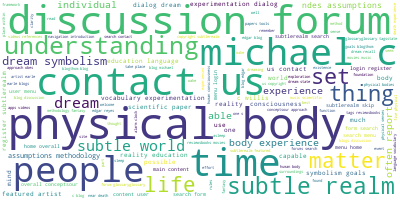

In [4]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

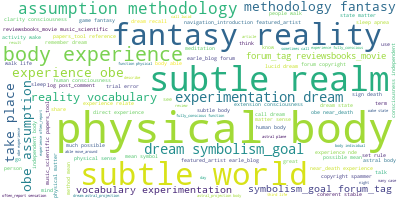

In [42]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join([','.join(d) for d in data_lemmatized])

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=3000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [62]:
# df= pd.DataFrame(data = )
df = pd.DataFrame(columns= ["bigram","relative_weight"], data=[[k,v] for k,v in wordcloud.words_.items()])
df.to_excel("C:\\subtlerealm\\results\\wordcloud.xlsx")

In [60]:
%pip install openpyxl

     -------------------------------------- 242.1/242.1 kB 1.9 MB/s eta 0:00:00
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [41]:
word_list[2]

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       ...,
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

In [15]:
long_string

['welcome,to,subtle,realm,subtlerealm,skip,to,main,content,user,menu,login,register,subtlerealm,search,form,search,menu,home,overall,conceptsour,approach,obes,and,ndes,assumptions,methodology,fantasy,to,reality,education,language,vocabulary,experimentation,dialog,dream,symbolism,goals,blogthom,blog,michael,blog,edgar,blog,discussion,forum,tags,reviewsbooks,movies,music,scientific,papers,tools,and,apps,videos,references,about,us,contact,us,welcome,to,subtle,realm,our,purpose,at,subtlerealmorg,is,to,provide,thought,resources,discussion,and,method,toward,exploration,of,the,approximately,third,of,our,lives,spent,in,what,is,commonly,called,sleep,we,all,spend,on,average,of,our,lives,asleep,if,one,wishes,to,be,conservative,about,it,we,could,just,say,third,of,our,lives,are,spent,in,state,we,know,almost,nothing,about,we,are,so,used,to,this,daily,event,that,almost,no,thought,is,given,to,the,fact,yet,in,some,other,circumstance,if,one,were,told,she,must,give,up,one,third,of,her,life,in,an,involunt

** **
#### Step 4: Prepare text for LDA analysis <a class="anchor\" id="data_preparation"></a>
** **

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [6]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','contact', 'us' \
    , 'welcome', 'skip', 'main', 'content', 'user', 'blog', 'menu', 'login', \
        'register', 'search', 'form', 'discussion' 'menu', 'home', 'overall'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['subtle', 'realm', 'subtlerealm', 'subtlerealm', 'conceptsour', 'approach', 'obes', 'ndes', 'assumptions', 'methodology', 'fantasy', 'reality', 'education', 'language', 'vocabulary', 'experimentation', 'dialog', 'dream', 'symbolism', 'goals', 'blogthom', 'michael', 'edgar', 'discussion', 'forum', 'tags', 'reviewsbooks', 'movies', 'music', 'scientific']


In [7]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


** **
#### Step 5: LDA model tranining <a class="anchor\" id="train_model"></a>
** **

To keep things simple, we'll keep all the parameters to default except for inputting the number of topics. For this tutorial, we will build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [8]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"body" + 0.011*"physical" + 0.010*"subtle" + 0.009*"dream" + '
  '0.008*"one" + 0.007*"experience" + 0.006*"subtlerealm" + 0.006*"world" + '
  '0.006*"consciousness" + 0.005*"time"'),
 (1,
  '0.015*"body" + 0.010*"physical" + 0.009*"one" + 0.009*"subtle" + '
  '0.006*"subtlerealm" + 0.006*"experiences" + 0.006*"discussion" + '
  '0.006*"dream" + 0.006*"consciousness" + 0.006*"people"'),
 (2,
  '0.013*"body" + 0.010*"physical" + 0.010*"dream" + 0.009*"subtlerealm" + '
  '0.008*"subtle" + 0.007*"one" + 0.006*"experience" + 0.006*"world" + '
  '0.005*"matter" + 0.005*"sleep"'),
 (3,
  '0.011*"physical" + 0.010*"body" + 0.008*"one" + 0.008*"subtle" + '
  '0.007*"dream" + 0.007*"consciousness" + 0.006*"time" + 0.006*"assumptions" '
  '+ 0.006*"world" + 0.005*"experiences"'),
 (4,
  '0.012*"body" + 0.009*"dream" + 0.009*"physical" + 0.008*"one" + '
  '0.007*"subtle" + 0.007*"people" + 0.006*"consciousness" + '
  '0.006*"experience" + 0.005*"time" + 0.005*"assumptions"'),
 (5,
 

In [ ]:
!python -m spacy download en_core_web_sm

In [23]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
#### Remove Stopwords, Make Bigrams and Lemmatize
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','contact', 'us' ,'subtlerealm'
    , 'welcome', 'skip', 'main', 'content', 'user', 'blog', 'menu', 'login', 
        'register', 'search', 'featured_artist','form', 'discussion' ,'menu','reviewsbooks_movie',
'earle_blog','featured_artist','years_month',   'home', 'overall', 'edgar_reye',"read"
,"book","time","thing",'edgar', 'dialog'])

new_stopwords = ['from', 'subject', 're', 'edu', 'use','contact', 'us' ,'subtlerealm'
    , 'welcome', 'skip', 'main', 'content', 'user', 'blog', 'menu', 'login', 
        'register', 'search', 'featured_artist','form', 'discussion' ,'menu','reviewsbooks_movie',
'earle_blog','featured_artist','years_month',   'home', 'overall', 'edgar_reye',"read","blogthom"
,"forum_tag","earle_blog","navigation_introduction","featured_artist","reviewbooks_movie","papers_tool"
,"book","time","thing",'edgar', 'dialog']

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    interim =[ [word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    return [ [word for word in simple_preprocess(str(doc)) if word not in new_stopwords ] for doc in interim]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

['welcome', 'to', 'subtle', 'realm', 'subtlerealm', 'skip', 'to', 'main', 'content', 'user', 'menu', 'login', 'register', 'subtlerealm', 'search', 'form', 'search', 'menu', 'home', 'overall', 'conceptsour', 'approach', 'obes', 'and', 'ndes', 'assumptions', 'methodology', 'fantasy', 'to', 'reality']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\andre\anaconda3\envs\subtlerealm\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.4.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


['subtle', 'realm', 'obe', 'assumption', 'methodology', 'fantasy', 'reality', 'vocabulary', 'experimentation', 'dream', 'symbolism_goal', 'forum_tag', 'reviewsbooks_movie', 'music_scientific', 'papers_tool', 'reference', 'subtle', 'realm', 'purpose', 'subtlerealmorg', 'provide', 'think', 'resource', 'method', 'exploration', 'approximately', 'third', 'life', 'spend', 'commonly']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1)]


In [25]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b, workers= 11)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()



[(0,
  '0.028*"dream" + 0.010*"remember" + 0.010*"wake" + 0.009*"sound" + '
  '0.008*"experience" + 0.008*"see" + 0.008*"make" + 0.007*"subtle" + '
  '0.007*"get" + 0.007*"recall"'),
 (1,
  '0.001*"body" + 0.001*"dream" + 0.001*"experience" + 0.001*"subtle" + '
  '0.001*"physical" + 0.001*"people" + 0.001*"life" + 0.001*"world" + '
  '0.001*"consciousness" + 0.001*"matter"'),
 (2,
  '0.048*"body" + 0.028*"subtle" + 0.026*"experience" + 0.022*"dream" + '
  '0.017*"review" + 0.017*"obe" + 0.014*"sleep" + 0.012*"reye" + 0.012*"world" '
  '+ 0.009*"adventure"'),
 (3,
  '0.015*"experimentation" + 0.015*"methodology" + 0.015*"symbolism_goal" + '
  '0.015*"vocabulary" + 0.015*"papers_tool" + 0.015*"forum_tag" + '
  '0.015*"copyright" + 0.015*"music_scientific" + 0.015*"reviewsbooks_movie" + '
  '0.015*"assumption"'),
 (4,
  '0.018*"article" + 0.018*"tag" + 0.008*"speculation" + 0.008*"cease" + '
  '0.007*"movie" + 0.004*"rise" + 0.004*"mark" + 0.004*"traumatic" + '
  '0.004*"uplift" + 0.004*"

In [26]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 4
max_topics = 9
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('C:\\subtlerealm\\results\\lda_tuning_results.csv', index=False)
    pbar.close()


100%|██████████| 300/300 [3:39:58<00:00, 43.99s/it]  


In [27]:
result_out = pd.read_csv("C:\\subtlerealm\\results\\lda_tuning_results.csv")
result_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Validation_Set  300 non-null    object 
 1   Topics          300 non-null    int64  
 2   Alpha           300 non-null    object 
 3   Beta            300 non-null    object 
 4   Coherence       300 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 11.8+ KB


In [28]:
result_out.sort_values('Coherence',ascending=False).head(1)

,Validation_Set,Topics,Alpha,Beta,Coherence
131,75% Corpus,8,0.61,0.31,0.460346


In [29]:
num_topics = 8
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.61,
                                           eta=0.31, workers = 11)
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.026*"dream" + 0.010*"remember" + 0.009*"wake" + 0.008*"subtle" + '
  '0.008*"sound" + 0.008*"experience" + 0.008*"see" + 0.007*"people" + '
  '0.007*"world" + 0.007*"make"'),
 (1,
  '0.020*"post" + 0.020*"forum" + 0.015*"new" + 0.013*"subtle" + 0.013*"world" '
  '+ 0.009*"years_month" + 0.009*"obe" + 0.009*"dream" + 0.007*"help" + '
  '0.007*"ago"'),
 (2,
  '0.031*"body" + 0.019*"dream" + 0.019*"experience" + 0.018*"subtle" + '
  '0.012*"review" + 0.011*"obe" + 0.009*"sleep" + 0.008*"world" + 0.008*"reye" '
  '+ 0.006*"life"'),
 (3,
  '0.009*"site" + 0.005*"mail" + 0.005*"new" + 0.004*"address" + '
  '0.004*"password" + 0.004*"username" + 0.004*"log" + 0.004*"dream" + '
  '0.003*"find" + 0.003*"enter"'),
 (4,
  '0.001*"body" + 0.001*"experience" + 0.001*"subtle" + 0.001*"dream" + '
  '0.001*"physical" + 0.001*"world" + 0.001*"post" + 0.001*"people" + '
  '0.001*"forum" + 0.001*"consciousness"'),
 (5,
  '0.001*"dream" + 0.001*"experience" + 0.001*"subtle" + 0.001*"remember" + 

In [32]:
doc_lda = lda_model[corpus]
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

In [33]:



LDAvis_data_filepath = os.path.join('C:\\subtlerealm\\results\\ldavis_final_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, 'C:\\subtlerealm\\results\\ldavis_final_'+ str(num_topics) +'.html')

LDAvis_prepared

c:\Users\andre\anaconda3\envs\subtlerealm\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.239384  0.020761       1        1  55.616406
0      0.059317  0.123720       2        1  26.194274
7      0.028316 -0.119799       3        1   8.798476
2     -0.005148 -0.036834       4        1   6.495680
3      0.040580 -0.012845       5        1   1.353084
1      0.023422 -0.008304       6        1   1.261379
5      0.047098  0.018875       7        1   0.140404
4      0.045798  0.014426       8        1   0.140297, topic_info=           Term        Freq       Total Category  logprob  loglift
173        body  455.000000  455.000000  Default  30.0000  30.0000
24        dream  386.000000  386.000000  Default  29.0000  29.0000
75       subtle  220.000000  220.000000  Default  28.0000  28.0000
279  experience  355.000000  355.000000  Default  27.0000  27.0000
87        world  166.000000  166.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
96        human    0.017659  119.590993   Topic8  -7.4860  -2.2514
344  individual    0.017614  113.503316   Topic8  -7.4885  -2.2017
233   different    0.017499   97.127847   Topic8  -7.4951  -2.0525
433    possible    0.017482  116.099733   Topic8  -7.4961  -2.2319
514        take    0.017455  113.858282   Topic8  -7.4976  -2.2139

[583 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
567       1  0.108680      ability
567       2  0.815097      ability
568       1  0.205528       accept
568       2  0.513821       accept
568       3  0.102764       accept
...     ...       ...          ...
88        3  0.440551         year
88        4  0.146850         year
88        6  0.036713         year
1534      3  0.557447  years_month
1534      6  0.418085  years_month

[739 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 8, 3, 4, 2, 6, 5])

** **
#### Step 6: Analyzing our LDA model <a class="anchor\" id="results"></a>
** **

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [9]:
import pyLDAvis
import pyLDAvis.gensim_models
import pickle 

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('C:\\subtlerealm\\results\\ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, 'C:\\subtlerealm\\results\\ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

c:\Users\andre\anaconda3\envs\subtlerealm\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.010067 -0.011859       1        1  46.380878
0      0.003735  0.004826       2        1  13.807849
6     -0.015452 -0.007288       3        1  11.149927
7      0.004986  0.000519       4        1  10.397855
4      0.009727  0.000853       5        1   7.096660
8     -0.007944  0.007789       6        1   5.322179
2     -0.003904  0.007377       7        1   2.782683
5      0.003361  0.005962       8        1   1.694679
1     -0.005901 -0.008213       9        1   1.175471
3      0.001325  0.000033      10        1   0.191818, topic_info=              Term        Freq       Total Category  logprob  loglift
232           body  468.000000  468.000000  Default  30.0000  30.0000
569       physical  260.000000  260.000000  Default  29.0000  29.0000
75             one  242.000000  242.000000  Default  28.0000  28.0000
103         subtle  216.000000  216.000000  Default  27.0000  27.0000
36           dream  222.000000  222.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
85           realm    0.185452   99.395983  Topic10  -5.7163  -0.0277
319       dreaming    0.187262  107.314924  Topic10  -5.7066  -0.0946
709  understanding    0.185208  106.763352  Topic10  -5.7177  -0.1005
502            may    0.195669  129.731051  Topic10  -5.6627  -0.2404
320         dreams    0.176977   99.737167  Topic10  -5.7631  -0.0779

[804 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
178       1  0.436478  able
178       2  0.157132  able
178       3  0.122214  able
178       4  0.087296  able
178       5  0.087296  able
...     ...       ...   ...
125       6  0.054881   yet
125       7  0.027441   yet
125       9  0.027441   yet
2666      1  0.407151  york
2666      3  0.407151  york

[1828 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 7, 8, 5, 9, 3, 6, 2, 4])

[Adapted from kapadias/mediumposts](https://github.com/kapadias/mediumposts)

** **
#### Closing Notes
Machine learning has become increasingly popular over the past decade, and recent advances in computational availability have led to exponential growth to people looking for ways how new methods can be incorporated to advance the field of Natural Language Processing.

Often, we treat topic models as black-box algorithms, but hopefully, this article addressed to shed light on the underlying math, and intuitions behind it, and high-level code to get you started with any textual data.

In the next article, we’ll go one step deeper into understanding how you can evaluate the performance of topic models, tune its hyper-parameters to get more intuitive and reliable results.

** **
#### References:
1. Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_model
2. Distributed Strategies for Topic Modeling. https://www.ideals.illinois.edu/bitstream/handle/2142/46405/ParallelTopicModels.pdf?sequence=2&isAllowed=y
3. Topic Mapping — Software — Resources — Amaral Lab. https://amaral.northwestern.edu/resources/software/topic-mapping
4. A Survey of Topic Modeling in Text Mining. https://thesai.org/Downloads/Volume6No1/Paper_21-A_Survey_of_Topic_Modeling_in_Text_Mining.pdf
